In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import natsort
import glob
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import gc

In [3]:
from filter import *

In [4]:
data_folder = 'data'
out_folder = 'output'

We have about 30k probe candidates designed for about 1100 OR and Taar genes, the goal is to filter and keep the better 10 probes for each OR for Barseq experiments.

In [5]:
# Load in the 30k probes:
probe_df = pd.read_csv(f'{data_folder}/monahan_panel_barcoded_2025_09_18.csv')

Number of genes with less than 10 probes: 49


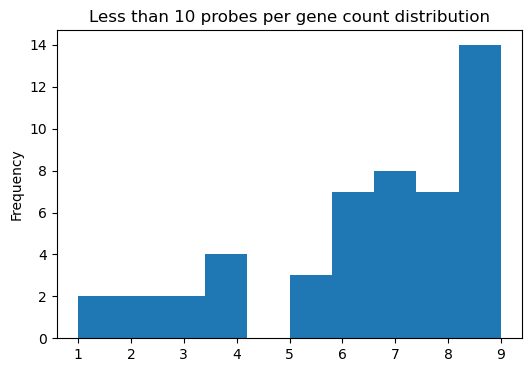

In [6]:
# Check that each gene has at least 10 probes designed, to be compared later
less_than_10_df_before = less_than_10_check(probe_df)

----
### 1. Secondary structure related features:

- here we will:
    - compute the first filtering mask based on the heterodimer percentage binding between probes;
    - read in the probe-target binding fraction feature.

In [7]:
hetero_perc_mat = pd.read_pickle(f"{data_folder}/heterodimer_nupack_percent_matrix.pkl")
homo_df = pd.read_csv(f'{data_folder}/monahan_panel_barcoded_NUPACK.csv')

In [8]:
# Read heterodimer percentage matrix:
P      = np.asarray(hetero_perc_mat["matrix"], dtype=float)  # (N,N), percentages in [0,1]
names  = np.asarray(hetero_perc_mat["names"], dtype=object)  # (N,)

In [9]:
# Initialize dataframe to hold filtering features, just for placeholding:
filter_raw_df = pd.DataFrame(
    {'hetero_perc_sum': np.asarray(P).sum(axis=0)},
    index=pd.Index(names, name='name')
)
filter_raw_df.head()

,hetero_perc_sum
name,
padlock_00001,144.778740
padlock_00002,23.469539
padlock_00003,20.004766
padlock_00004,33.293592
padlock_00005,18.695895


Visualize per probe summed percentage binding to other probes; exclude outliers (beyond dotted line)

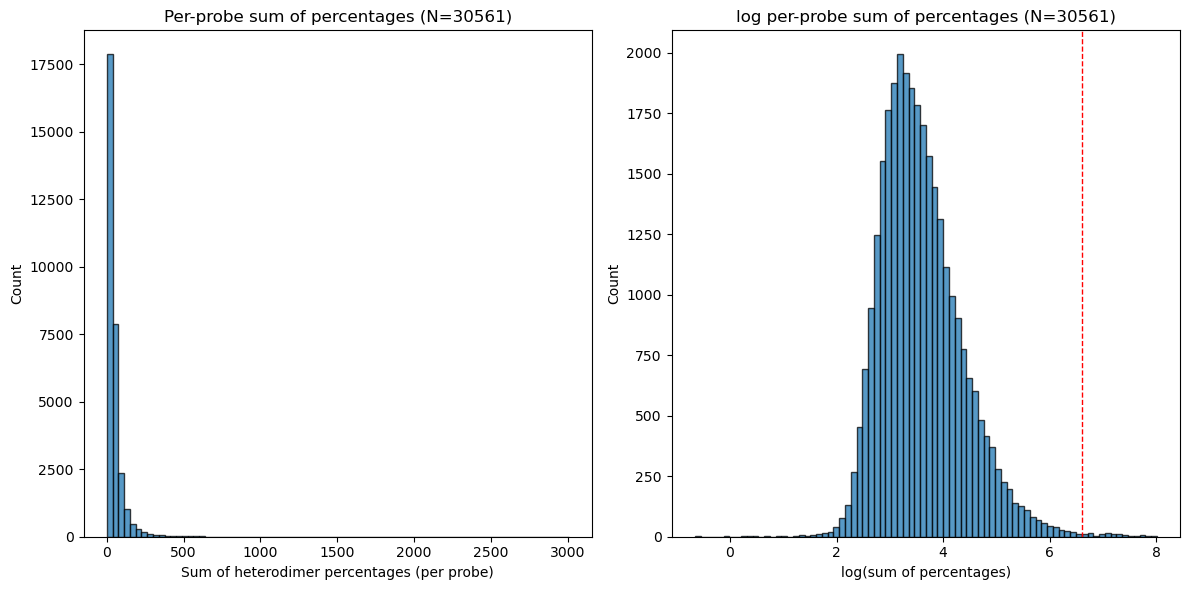

In [10]:
N = P.shape[0]
sum_frac = P.sum(axis=1)  

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

# Hist sums
ax[0].hist(sum_frac, bins=80, edgecolor="black", alpha=0.75)
ax[0].set_xlabel("Sum of heterodimer percentages (per probe)")
ax[0].set_ylabel("Count")
ax[0].set_title(f"Per-probe sum of percentages (N={N})")

# Hist log-sums
eps = 1e-12
log_sum = np.log(sum_frac + eps)
ax[1].hist(log_sum, bins=80, edgecolor="black", alpha=0.75)
ax[1].set_xlabel("log(sum of percentages)")
ax[1].set_ylabel("Count")
ax[1].set_title(f"log per-probe sum of percentages (N={N})")
ax[1].axvline(6.6, color='red', linestyle='dashed', linewidth=1)
plt.tight_layout()
plt.show()


Sainity check: what does the individual binding percent distribution looks like?

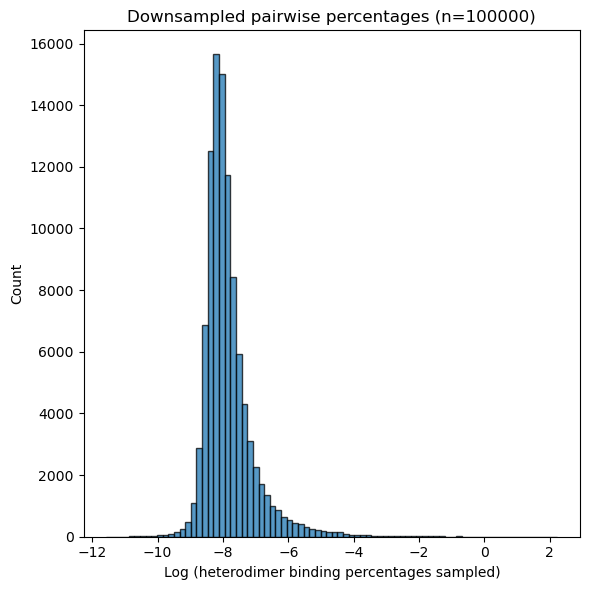

In [11]:
# Downsample hetero-interaction entries:
offdiag = ~np.eye(N, dtype=bool)
ii, jj = np.where(offdiag)

# sample 100000 points:
K = min(100000, ii.size) 
rng = np.random.default_rng(2025)
idx = rng.choice(ii.size, size=K, replace=False)
sample_vals = P[ii[idx], jj[idx]]
log_sample = np.log(sample_vals + eps)

plt.figure(figsize=(6,6))
plt.hist(log_sample, bins=80, edgecolor="black", alpha=0.75)
plt.xlabel("Log (heterodimer binding percentages sampled)")
plt.ylabel("Count")
plt.title(f"Downsampled pairwise percentages (n={K})")
plt.tight_layout()
plt.show()

In [12]:
# I used trial-and-error to pick remove_frac=0.01:
keep_mask_hetero_offenders, log_df = drop_global_offenders(P, names, remove_frac=0.01)

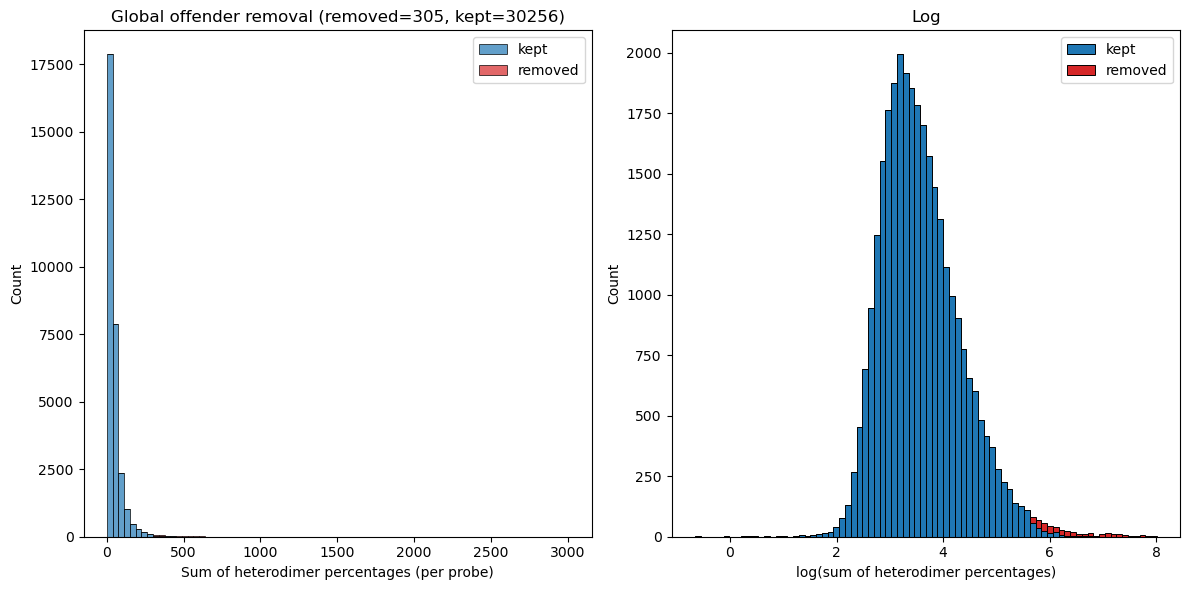

In [13]:
sum_before = sum_frac
sum_after  = sum_frac[keep_mask_hetero_offenders]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].hist([sum_after, sum_before[~keep_mask_hetero_offenders]],
           bins=80, stacked=True, label=["kept", "removed"],
           edgecolor="black", linewidth=0.7, alpha=0.7, color=["C0","C3"])
ax[0].set_xlabel("Sum of heterodimer percentages (per probe)")
ax[0].legend()
ax[0].set_ylabel("Count")
ax[0].set_title(f"Global offender removal (removed={(~keep_mask_hetero_offenders).sum()}, kept={keep_mask_hetero_offenders.sum()})")
ax[0].legend()

sum_before = P.sum(axis=1)                    # per-probe sums on full matrix
log_before = np.log(sum_before + eps)

log_before_kept    = log_before[keep_mask_hetero_offenders]
log_before_removed = log_before[~keep_mask_hetero_offenders]

ax[1].hist([log_before_kept, log_before_removed],
           bins=80, stacked=True,
           edgecolor="black", linewidth=0.7, 
           label=["kept", "removed"],
           color=["C0","C3"])
ax[1].set_xlabel("log(sum of heterodimer percentages)")
ax[1].set_ylabel("Count")
ax[1].set_title(f"Log")
ax[1].legend()
plt.tight_layout()
plt.show()

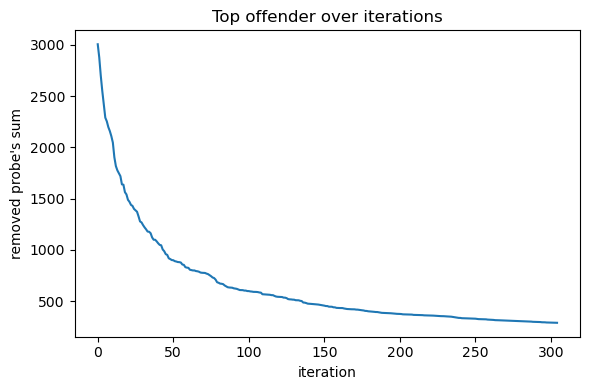

In [14]:
plt.figure(figsize=(6,4))
plt.plot(log_df["iter"], log_df["sum_before"], lw=1.5)
plt.xlabel("iteration")
plt.ylabel("removed probe's sum")
plt.title("Top offender over iterations")
plt.tight_layout(); plt.show()

In [15]:
# free memory
del hetero_perc_mat, P, names, offdiag, ii, jj, log_sample

Number of genes with less than 10 probes: 52


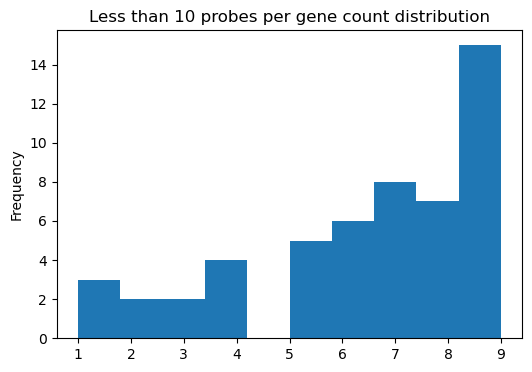

In [16]:
less_than_10_df_round1 = less_than_10_check(probe_df[keep_mask_hetero_offenders]) 
less_than_10_df_round1.to_csv(f'{out_folder}/less_than_10_probes_102825.csv', index=False)

Include binding efficiency feature to the filter df:

In [17]:
# keep only binding fraction columns, rename padlock_name to name
homo_cols = (
    homo_df[['padlock_name', 'half1_any_fraction', 'half2_any_fraction']]
      .rename(columns={'padlock_name': 'name'})
)

# merge binding fraction onto filter_raw_df:
filter_raw_df = filter_raw_df.merge(
    homo_cols,
    on='name',
    how='left',
    validate='m:1'   
)

---

### 2. BLAST result related features

Here we will include:

- the melting temp difference between two arms;
- the low affinity off target binding 

In [18]:
annot_df  = pd.read_csv(f'{data_folder}/olfr_consensus_cds_3utr_annotations.csv')
blast_df = pd.read_csv(f"{data_folder}/Olfrs_monahan_BLAST_Tm_results_2025_09_18.csv")

In [19]:
# Set the temperature threshold to be 30C, such that we keep considering for the low affinity binding
# but also exclude the very weak bindings

temp = 30

# Note that some of self binding is also < 37C, but 30 is enough to include them all
self_df_olfr = blast_df[(blast_df.gene == blast_df.blast_target) &
                        (blast_df.ligation_site_missmatch == False) &
                         (blast_df.tm_left_melting > temp) & (blast_df.tm_right_melting > temp) &
                   (blast_df.subject.str.startswith("Olfr"))]

self_df_taar = blast_df[(blast_df.gene == blast_df.blast_target) &
                        (blast_df.ligation_site_missmatch == False) &
                        (blast_df.tm_left_melting > temp) & (blast_df.tm_right_melting > temp) &
                   (blast_df.gene.str.startswith("Taar"))]

In [20]:
self_df = pd.concat([self_df_olfr, self_df_taar], ignore_index=True)

In [21]:
self_df['tm_melting_diff'] = abs(self_df.tm_right_melting -self_df.tm_left_melting)

In [22]:
self_df_collapsed = collapse_duplicated(self_df, subject_col="subject", verbose=True)

/Users/xinzheng/Repos/receptor_probe_filtering/filter.py:117: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  report = g.apply(


Dropped columns: ['sstart', 'send']
Rows before: 47839
Rows after:  30657


/Users/xinzheng/Repos/receptor_probe_filtering/filter.py:141: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged.groupby(key_cols, dropna=False, sort=False, group_keys=False)


In [23]:
# keep, per query, the row with the highest (tm_left_NN + tm_right_NN)
# this is to prevent mutlitple matching between the same probe and gene
_score = self_df_collapsed['tm_left_NN'] + self_df_collapsed['tm_right_NN']
self_df_collapsed = (
    self_df_collapsed
      .assign(_score=_score)
      .sort_values('_score', ascending=False) # best first
      .drop_duplicates(subset='query', keep='first')    # keep best per query
      .drop(columns='_score')
      .sort_values('query')    # final sort by query, to align column index
      .reset_index(drop=True)
)

# count rows after dropping, should match the number of probes designed
num_rows = len(self_df_collapsed)
print(num_rows)

30561


In [24]:
cols = (self_df_collapsed[['query', 'tm_melting_diff']].rename(columns={'query': 'name'}))
filter_raw_df = filter_raw_df.merge(cols, on='name', how='left', validate='m:1')

Include low affinity binding:

In [25]:
# Now filter off-target hits the ones that have melting temperature  > 30C 
valid_off_df = blast_df[  (blast_df.ligation_site_missmatch == False) &  
                        (blast_df.tm_left_melting > temp) & (blast_df.tm_right_melting > temp) &
                       (blast_df.blast_target != blast_df.gene) ] 

len(valid_off_df) # number of off-target hits with Tm > 30C

58770

In [26]:
del blast_df # free memory

In [27]:
# Remove duplicate off-target hits by choosing the one with the highest sum of left right arm melting temperatures
_score = valid_off_df['tm_left_melting'] + valid_off_df['tm_right_melting']

valid_off_df = (
    valid_off_df
      .assign(_score=_score)
      .sort_values('_score', ascending=False)
      .drop_duplicates(subset=['query', 'blast_target'], keep='first')
      .drop(columns='_score')
      .reset_index(drop=True)
)

In [28]:
valid_off_df

,query,subject,percentage identity,length,mismatches,gaps,qstart,qend,sstart,send,...,valid_probe_NN,ligation_site_missmatch,specific,tm_left_melting,tm_right_melting,valid_probe_melting,left_length,right_length,valid_specific_row,valid_non_specific_row
0,padlock_01720,Olfr1427|OTTMUSG00000059439|OTTMUST00000145880,90.000,40,4,0,1,40,639,678,...,False,False,False,54.07,54.63,True,20,20,False,False
1,padlock_24376,ENSMUST00000141187.8,82.051,39,5,2,2,40,4086,4122,...,False,False,False,59.18,48.76,True,19,20,False,False
2,padlock_07780,ENSMUST00000055146.4,82.500,40,7,0,1,40,709,748,...,False,False,False,55.26,52.21,True,20,20,False,False
3,padlock_20649,ENSMUST00000130213.2,92.500,40,3,0,1,40,617,656,...,False,False,False,54.41,52.42,True,20,20,False,False
4,padlock_15029,ENSMUST00000208970.3,87.500,40,5,0,1,40,799,838,...,False,False,False,51.59,54.01,True,20,20,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21087,padlock_13615,ENSMUST00000129271.8,88.462,26,0,2,8,32,2546,2569,...,False,False,False,30.04,30.19,False,13,13,False,False
21088,padlock_10475,Olfr782|OTTMUSG00000056563|OTTMUST00000139698,83.784,37,4,2,5,40,677,712,...,False,False,False,30.20,30.01,False,17,20,False,False
21089,padlock_10475,Olfr804|OTTMUSG00000056621|OTTMUST00000139781,83.784,37,4,2,5,40,911,946,...,False,False,False,30.20,30.01,False,17,20,False,False
21090,padlock_10475,ENSMUST00000222301.2,83.784,37,4,2,5,40,297,332,...,False,False,False,30.20,30.01,False,17,20,False,False


In [29]:
# sum over target for per query in valid_off_df
tm_cols = ['tm_left_melting', 'tm_right_melting']
sums_by_query = (
    valid_off_df[['query'] + tm_cols]
      .groupby('query', as_index=True)[tm_cols]
      .sum()
      .rename(columns={
          'tm_left_melting': 'tm_left_melting_sum',
          'tm_right_melting': 'tm_right_melting_sum'
      })
)

# build summed_temp_df with one row per name in filter_raw_df, preserving 
# order of padlocks by filling no off-target sum with 0
names_in_order = filter_raw_df['name'].drop_duplicates()
summed_temp_df = (
    pd.DataFrame({'name': names_in_order})
      .merge(sums_by_query, how='left', left_on='name', right_index=True)
      .fillna({'tm_left_melting_sum': 0, 'tm_right_melting_sum': 0})
      .reset_index(drop=True)
)

In [30]:
summed_temp_df.head()

,name,tm_left_melting_sum,tm_right_melting_sum
0,padlock_00001,0.00,0.00
1,padlock_00002,32.88,44.04
2,padlock_00003,33.78,44.60
3,padlock_00004,0.00,0.00
4,padlock_00005,0.00,0.00


In [31]:
# merge summed temps into filter_raw_df
filter_raw_df = (
    filter_raw_df
      .merge(
          summed_temp_df[['name', 'tm_left_melting_sum', 'tm_right_melting_sum']],
          on='name',
          how='left',
          validate='m:1'
      )
)

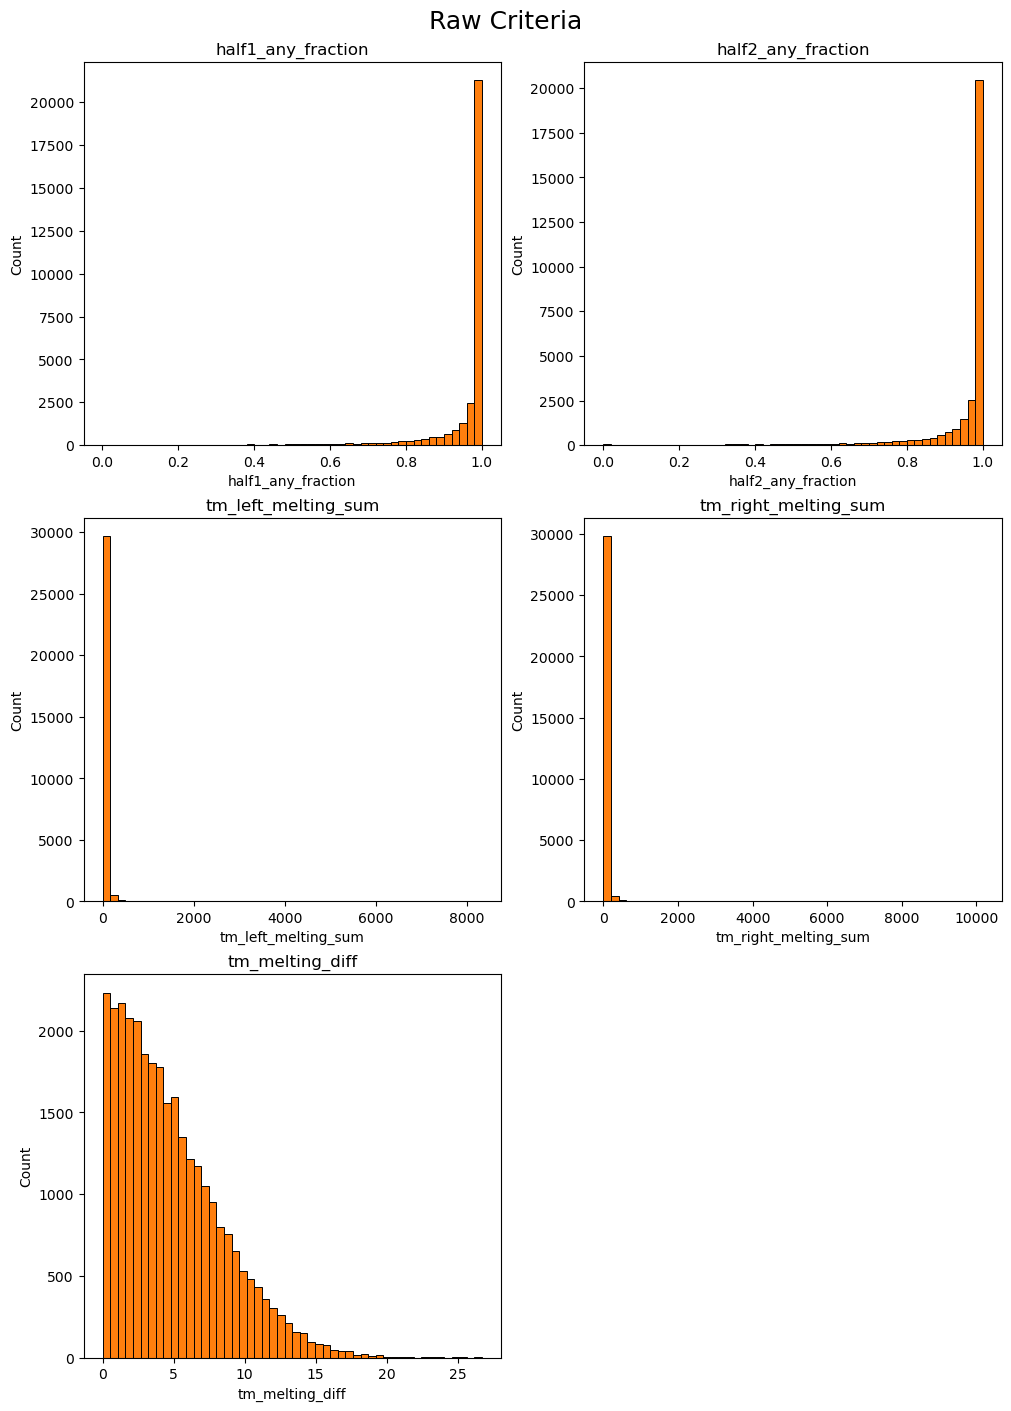

In [32]:
# Columns to visualize
cols = [
    'half1_any_fraction', 'half2_any_fraction',
    'tm_left_melting_sum', 'tm_right_melting_sum',
    'tm_melting_diff'
]

fig, axes = plt.subplots(3, 2, figsize=(10, 14), constrained_layout=True)
axes = axes.ravel()

for ax, col in zip(axes, cols):
    ax.hist(filter_raw_df[col], bins=50,
            edgecolor="black", linewidth=0.7, 
            color='C1')
    ax.set_title(f"{col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

# turn off any unused subplots (if fewer than 6 columns)
for k in range(len(cols), len(axes)):
    axes[k].axis("off")

plt.suptitle("Raw Criteria", fontsize=18)
plt.show()

Turn them into single raw features by combining left and right:

In [33]:
# --- binding_fraction ---
# take the smaller of the two percentages, to be conservative
frac_min = np.fmin(filter_raw_df['half1_any_fraction'], filter_raw_df['half2_any_fraction'])
filter_raw_df['binding_fraction'] = frac_min


In [34]:
# --- off_target_combined ---
tm_sum = filter_raw_df['tm_left_melting_sum'] + filter_raw_df['tm_right_melting_sum']
filter_raw_df['off_target_combined'] = tm_sum

In [35]:
filter_df= filter_raw_df[['name', 'tm_melting_diff', 'binding_fraction', 'off_target_combined']]

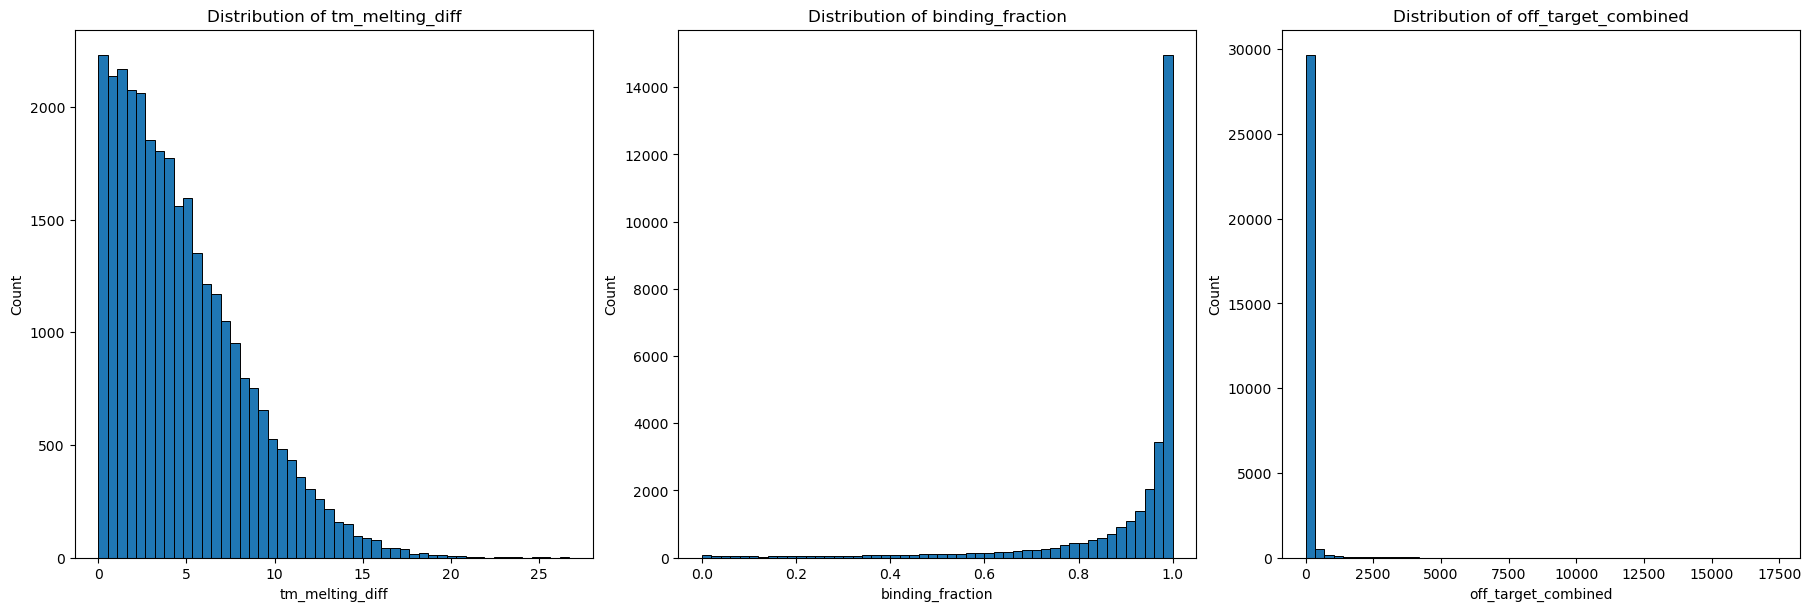

In [36]:
cols = ['tm_melting_diff', 'binding_fraction', 'off_target_combined']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for ax, col in zip(axes, cols):
    ax.hist(
        filter_df[col],
        bins=50,
        edgecolor="black",
        linewidth=0.7,
        color="C0",
    )
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    
plt.show()

#### Soft selection transfer function (2.0)

Previously, we rely on z-scores (1.0). However, z-score still depends on the original distribution shapes, and the 3 distribution cannot easily standardized to be normal-like with the same spread.

Now we devised a function targetting at one desired tail to punish. Detail see filtering doc.

In [37]:
# --- build tail scores for three metrics ---
df = filter_raw_df.copy()

s_tm   = tail_signed_score(df["tm_melting_diff"],  direction="upper", method="logit")    # higher worse
s_bind = tail_signed_score(df["binding_fraction"], direction="lower", method="logit")    # lower worse 
s_off  = tail_signed_score(df["off_target_combined"], direction="upper", method="logit") # higher worse

# clip so a few points don't explode everything
s_cap = 8.0
s_tm   = np.clip(s_tm,  -s_cap, s_cap)
s_bind = np.clip(s_bind,-s_cap, s_cap)
s_off  = np.clip(s_off, -s_cap, s_cap)

# --- exponential scaling (same as previous form) ---
w = {"tm":1.0, "bind":1.0, "off":1.0}
beta = {"tm":1.0, "bind":1.0, "off":1.0}   # tune if you want relative emphasis

df["term_tm"]   = w["tm"]   * np.exp(beta["tm"]   * s_tm)
df["term_bind"] = w["bind"] * np.exp(beta["bind"] * s_bind)
df["term_off"]  = w["off"]  * np.exp(beta["off"]  * s_off)

df["score_total"] = df["term_tm"] + df["term_bind"] + df["term_off"]

In [38]:
# copy over to filter_df
filter_df["score_total"] = df["score_total"]

/var/folders/45/vxs3qxtn0ql1mmj2dm1w3zxw0000gp/T/ipykernel_42476/2050045257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df["score_total"] = df["score_total"]


In [39]:
filter_df['gene'] = probe_df['acronym']

/var/folders/45/vxs3qxtn0ql1mmj2dm1w3zxw0000gp/T/ipykernel_42476/1926290102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df['gene'] = probe_df['acronym']


---
## filtering steps:

### 1. drop the offenders:

In [40]:
gene_wise_filter_df = filter_df.loc[keep_mask_hetero_offenders].copy()
gene_wise_filter_df

,name,tm_melting_diff,binding_fraction,off_target_combined,score_total,gene
0,padlock_00001,0.08,0.995565,0.00,1.025214,Or7e175
1,padlock_00002,2.47,0.996329,76.92,5.742513,Or7e175
2,padlock_00003,1.00,0.973306,78.38,6.619084,Or7e175
3,padlock_00004,3.71,0.948963,0.00,3.327087,Or7e175
4,padlock_00005,6.64,0.922270,0.00,5.815086,Or7e175
...,...,...,...,...,...,...
30556,padlock_30557,12.67,0.994262,0.00,28.886646,Taar6
30557,padlock_30558,5.23,0.883153,0.00,5.723394,Taar6
30558,padlock_30559,10.67,0.960900,0.00,14.124742,Taar6
30559,padlock_30560,12.30,0.670817,0.00,35.246201,Taar6


### 2. keep 10 best combined scores:

In [42]:
gene_wise_filter_df = gene_wise_filter_df.rename(columns={'name': 'padlock_name'})

all_names = filter_df["name"].to_numpy()  # original order

df_sub = gene_wise_filter_df              # already subset by prior global drop
prior_mask = keep_mask_hetero_offenders  

out_df, keep_mask_full = keep_top_per_gene(
    df_sub,
    score_col="score_total",
    gene_col="gene",
    name_col="padlock_name",              
    max_per_gene=10,
    add_overall_ranks=True,
    all_names=all_names,
    prior_keep_mask=prior_mask,
    return_full_mask=True,
)

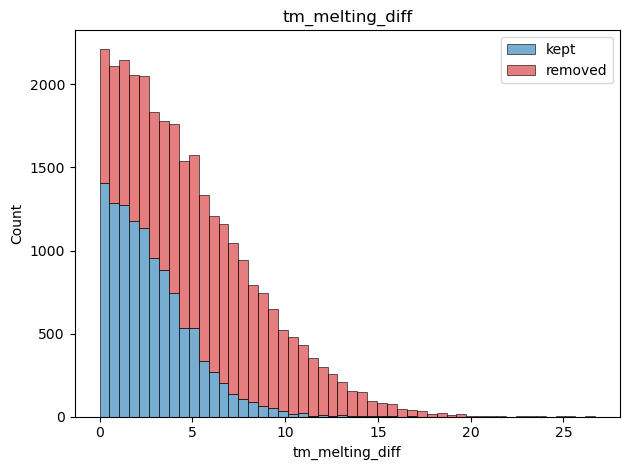

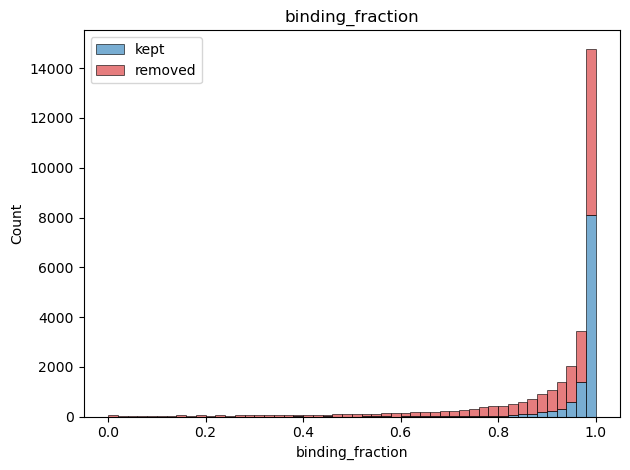

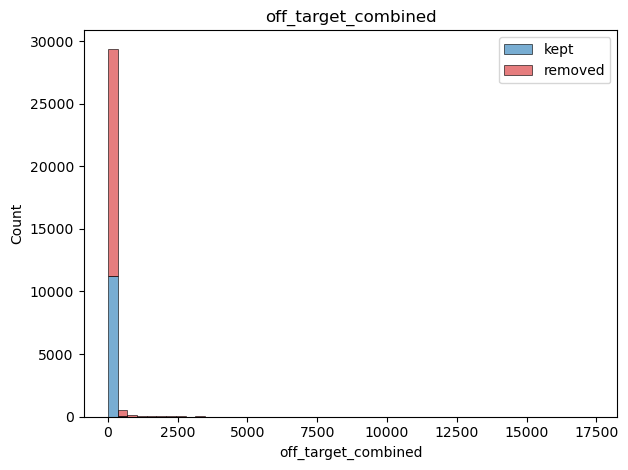

In [43]:
for col in cols:

    plt.figure()
    
    x_keep = out_df.loc[out_df["keep"],  col]
    x_drop = out_df.loc[~out_df["keep"], col]

    plt.hist(
        [x_keep, x_drop],
        bins=50,
        stacked=True,
        edgecolor="black",
        linewidth=0.7,
        alpha=0.6,
        label=["kept", "removed"],
        color=["C0", "C3"],
    )
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"{col}")
    plt.legend()
    plt.tight_layout()
    plt.show()


Organize output:

In [44]:
probe_df = probe_df.drop(columns=['best_heterodimer_partner', 
                       'best_heterodimer_dg_kcalmol', 
                       'homodimer_dg_kcalmol',
                       'hairpin_dg_kcalmol',
                       'name'])

In [45]:
probe_df['keep_1st_round'] = keep_mask_hetero_offenders
probe_df['keep_2nd_round'] = keep_mask_full

In [46]:
probe_df.index = probe_df['padlock_name']

In [47]:
probe_df = probe_df.drop(columns=['padlock_name','Tm'])

In [48]:
desired = [
    'gene_name', 'acronym', 'target', 'transcript_region',
    'startpos', 'endpos', 'barcode', 'RT primer', 'padlock',  'keep_1st_round', 'keep_2nd_round',
]
probe_df = probe_df.reindex(columns=desired)

probe_df

,gene_name,acronym,target,transcript_region,startpos,endpos,barcode,RT primer,padlock,keep_1st_round,keep_2nd_round
padlock_name,,,,,,,,,,,
padlock_00001,Olfr869,Or7e175,AACAACACAGAAGCACAGAATCTACCAGTTGTCTCACAGT,['CDS'],37,76,CACTATCGTC,ACTGTGAGACAACTGGTAGA,TCTACCAGTTGTCTCACAGTATCGTCGGACTGTAGAACTCTGAACC...,True,True
padlock_00002,Olfr869,Or7e175,GAGAACGTAGAAGTACAGCCTTTCCTACTTGTGCTGTTTT,['CDS'],97,136,CACTATCGTC,AAAACAGCACAAGTAGGAAA,TTTCCTACTTGTGCTGTTTTATCGTCGGACTGTAGAACTCTGAACC...,True,True
padlock_00003,Olfr869,Or7e175,TGCATGTATGGATAGTATGCTTCTGACTGTAATGGCCTAT,['CDS'],363,402,CACTATCGTC,ATAGGCCATTACAGTCAGAA,TTCTGACTGTAATGGCCTATATCGTCGGACTGTAGAACTCTGAACC...,True,False
padlock_00004,Olfr869,Or7e175,GTGCTACAATTTACACACTTCAGTGGCATGGAAATCTCTA,['CDS'],529,568,CACTATCGTC,TAGAGATTTCCATGCCACTG,CAGTGGCATGGAAATCTCTAATCGTCGGACTGTAGAACTCTGAACC...,True,True
padlock_00005,Olfr869,Or7e175,TATTGTGATCCTTCCCAACTTCTTAATCTTAACTGTTCTG,['CDS'],574,613,CACTATCGTC,CAGAACAGTTAAGATTAAGA,TCTTAATCTTAACTGTTCTGATCGTCGGACTGTAGAACTCTGAACC...,True,False
...,...,...,...,...,...,...,...,...,...,...,...
padlock_30557,Taar6,Taar6,AACCCTGGGGATTACCGTGGTAGCATTCATGATATCATGG,['CDS'],774,813,CATCGCCTTT,CCATGATATCATGAATGCTA,TAGCATTCATGATATCATGGATCGTCGGACTGTAGAACTCTGAACC...,True,False
padlock_30558,Taar6,Taar6,CTACAGCATTGATTCATTAGTTGATGCTTTTATGGGCTTC,['CDS'],819,858,CATCGCCTTT,GAAGCCCATAAAAGCATCAA,TTGATGCTTTTATGGGCTTCATCGTCGGACTGTAGAACTCTGAACC...,True,True
padlock_30559,Taar6,Taar6,CTCAGCCATGAACCCTCTGATCTACGCTTTATTTTATCCA,['CDS'],909,948,CATCGCCTTT,TGGATAAAATAAAGCGTAGA,TCTACGCTTTATTTTATCCAATCGTCGGACTGTAGAACTCTGAACC...,True,True


In [49]:
# smallest value -> rank 1
out_df["rank_off_target_combined"] = (
    out_df["off_target_combined"]
      .rank(method="min", ascending=True)
      .astype("Int64")
) # ties get the same (minimum) rank, as we are have a lot of zeros

out_df["rank_tm_melting_diff"] = (
    out_df["tm_melting_diff"]
      .rank(method="min", ascending=True)
      .astype("Int64")
)

# largest value, rank 1 
out_df["rank_binding_fraction"] = (
    out_df["binding_fraction"]
      .rank(method="min", ascending=False)
)


In [51]:
probe_df

,gene_name,acronym,target,transcript_region,startpos,endpos,barcode,RT primer,padlock,keep_1st_round,keep_2nd_round
padlock_name,,,,,,,,,,,
padlock_00001,Olfr869,Or7e175,AACAACACAGAAGCACAGAATCTACCAGTTGTCTCACAGT,['CDS'],37,76,CACTATCGTC,ACTGTGAGACAACTGGTAGA,TCTACCAGTTGTCTCACAGTATCGTCGGACTGTAGAACTCTGAACC...,True,True
padlock_00002,Olfr869,Or7e175,GAGAACGTAGAAGTACAGCCTTTCCTACTTGTGCTGTTTT,['CDS'],97,136,CACTATCGTC,AAAACAGCACAAGTAGGAAA,TTTCCTACTTGTGCTGTTTTATCGTCGGACTGTAGAACTCTGAACC...,True,True
padlock_00003,Olfr869,Or7e175,TGCATGTATGGATAGTATGCTTCTGACTGTAATGGCCTAT,['CDS'],363,402,CACTATCGTC,ATAGGCCATTACAGTCAGAA,TTCTGACTGTAATGGCCTATATCGTCGGACTGTAGAACTCTGAACC...,True,False
padlock_00004,Olfr869,Or7e175,GTGCTACAATTTACACACTTCAGTGGCATGGAAATCTCTA,['CDS'],529,568,CACTATCGTC,TAGAGATTTCCATGCCACTG,CAGTGGCATGGAAATCTCTAATCGTCGGACTGTAGAACTCTGAACC...,True,True
padlock_00005,Olfr869,Or7e175,TATTGTGATCCTTCCCAACTTCTTAATCTTAACTGTTCTG,['CDS'],574,613,CACTATCGTC,CAGAACAGTTAAGATTAAGA,TCTTAATCTTAACTGTTCTGATCGTCGGACTGTAGAACTCTGAACC...,True,False
...,...,...,...,...,...,...,...,...,...,...,...
padlock_30557,Taar6,Taar6,AACCCTGGGGATTACCGTGGTAGCATTCATGATATCATGG,['CDS'],774,813,CATCGCCTTT,CCATGATATCATGAATGCTA,TAGCATTCATGATATCATGGATCGTCGGACTGTAGAACTCTGAACC...,True,False
padlock_30558,Taar6,Taar6,CTACAGCATTGATTCATTAGTTGATGCTTTTATGGGCTTC,['CDS'],819,858,CATCGCCTTT,GAAGCCCATAAAAGCATCAA,TTGATGCTTTTATGGGCTTCATCGTCGGACTGTAGAACTCTGAACC...,True,True
padlock_30559,Taar6,Taar6,CTCAGCCATGAACCCTCTGATCTACGCTTTATTTTATCCA,['CDS'],909,948,CATCGCCTTT,TGGATAAAATAAAGCGTAGA,TCTACGCTTTATTTTATCCAATCGTCGGACTGTAGAACTCTGAACC...,True,True


In [52]:
cols_to_include = [
    "padlock_name",
    "rank_off_target_combined",
    "rank_tm_melting_diff",
    "rank_binding_fraction",
    "rank_overall_best",
    "overall_percentile",
    "rank_in_gene_best",
]

probe_final_df = probe_df.merge(
    out_df[cols_to_include],
    on="padlock_name",
    how="left"
)

In [53]:
probe_final_df

,padlock_name,gene_name,acronym,target,transcript_region,startpos,endpos,barcode,RT primer,padlock,keep_1st_round,keep_2nd_round,rank_off_target_combined,rank_tm_melting_diff,rank_binding_fraction,rank_overall_best,overall_percentile,rank_in_gene_best
0,padlock_00001,Olfr869,Or7e175,AACAACACAGAAGCACAGAATCTACCAGTTGTCTCACAGT,['CDS'],37,76,CACTATCGTC,ACTGTGAGACAACTGGTAGA,TCTACCAGTTGTCTCACAGTATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,263,8105.0,1362.0,0.044999,2.0
1,padlock_00002,Olfr869,Or7e175,GAGAACGTAGAAGTACAGCCTTTCCTACTTGTGCTGTTTT,['CDS'],97,136,CACTATCGTC,AAAACAGCACAAGTAGGAAA,TTTCCTACTTGTGCTGTTTTATCGTCGGACTGTAGAACTCTGAACC...,True,True,25215,9780,7347.0,15885.0,0.525102,10.0
2,padlock_00003,Olfr869,Or7e175,TGCATGTATGGATAGTATGCTTCTGACTGTAATGGCCTAT,['CDS'],363,402,CACTATCGTC,ATAGGCCATTACAGTCAGAA,TTCTGACTGTAATGGCCTATATCGTCGGACTGTAGAACTCTGAACC...,True,False,25501,4029,16251.0,17212.0,0.568995,13.0
3,padlock_00004,Olfr869,Or7e175,GTGCTACAATTTACACACTTCAGTGGCATGGAAATCTCTA,['CDS'],529,568,CACTATCGTC,TAGAGATTTCCATGCCACTG,CAGTGGCATGGAAATCTCTAATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,14112,19473.0,11076.0,0.366126,6.0
4,padlock_00005,Olfr869,Or7e175,TATTGTGATCCTTCCCAACTTCTTAATCTTAACTGTTCTG,['CDS'],574,613,CACTATCGTC,CAGAACAGTTAAGATTAAGA,TCTTAATCTTAACTGTTCTGATCGTCGGACTGTAGAACTCTGAACC...,True,False,1,22111,21499.0,16015.0,0.529399,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30556,padlock_30557,Taar6,Taar6,AACCCTGGGGATTACCGTGGTAGCATTCATGATATCATGG,['CDS'],774,813,CATCGCCTTT,CCATGATATCATGAATGCTA,TAGCATTCATGATATCATGGATCGTCGGACTGTAGAACTCTGAACC...,True,False,1,29216,9141.0,26844.0,0.887411,12.0
30557,padlock_30558,Taar6,Taar6,CTACAGCATTGATTCATTAGTTGATGCTTTTATGGGCTTC,['CDS'],819,858,CATCGCCTTT,GAAGCCCATAAAAGCATCAA,TTGATGCTTTTATGGGCTTCATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,18744,23476.0,15845.0,0.523780,6.0
30558,padlock_30559,Taar6,Taar6,CTCAGCCATGAACCCTCTGATCTACGCTTTATTTTATCCA,['CDS'],909,948,CATCGCCTTT,TGGATAAAATAAAGCGTAGA,TCTACGCTTTATTTTATCCAATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,27938,18083.0,23335.0,0.771401,9.0
30559,padlock_30560,Taar6,Taar6,TAAGAAAGCTATTAAGGTTATTATGAGTGGCCAGGTGTTC,['CDS'],954,993,CATCGCCTTT,GAACACCTGGCCACTCATAA,TTATGAGTGGCCAGGTGTTCATCGTCGGACTGTAGAACTCTGAACC...,True,False,1,29047,27730.0,27474.0,0.908266,14.0


In [54]:
probe_keep_df = probe_final_df[probe_final_df["keep_2nd_round"] == True].copy()

In [55]:
probe_keep_df

,padlock_name,gene_name,acronym,target,transcript_region,startpos,endpos,barcode,RT primer,padlock,keep_1st_round,keep_2nd_round,rank_off_target_combined,rank_tm_melting_diff,rank_binding_fraction,rank_overall_best,overall_percentile,rank_in_gene_best
0,padlock_00001,Olfr869,Or7e175,AACAACACAGAAGCACAGAATCTACCAGTTGTCTCACAGT,['CDS'],37,76,CACTATCGTC,ACTGTGAGACAACTGGTAGA,TCTACCAGTTGTCTCACAGTATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,263,8105.0,1362.0,0.044999,2.0
1,padlock_00002,Olfr869,Or7e175,GAGAACGTAGAAGTACAGCCTTTCCTACTTGTGCTGTTTT,['CDS'],97,136,CACTATCGTC,AAAACAGCACAAGTAGGAAA,TTTCCTACTTGTGCTGTTTTATCGTCGGACTGTAGAACTCTGAACC...,True,True,25215,9780,7347.0,15885.0,0.525102,10.0
3,padlock_00004,Olfr869,Or7e175,GTGCTACAATTTACACACTTCAGTGGCATGGAAATCTCTA,['CDS'],529,568,CACTATCGTC,TAGAGATTTCCATGCCACTG,CAGTGGCATGGAAATCTCTAATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,14112,19473.0,11076.0,0.366126,6.0
7,padlock_00008,Olfr869,Or7e175,GAACAGCTACTGCAGTATACATTGGTTCAACCTCATCATA,['CDS'],800,839,CACTATCGTC,TATGATGAGGTTGAACCAAT,ATTGGTTCAACCTCATCATAATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,6086,22691.0,12458.0,0.411803,8.0
9,padlock_00010,Olfr869,Or7e175,CATCTACAGCCTGAGGAACAGGGACATTAAAATTGCCCTA,['CDS'],906,945,CACTATCGTC,TAGGGCAATTTTAATGTCCC,GGGACATTAAAATTGCCCTAATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,14436,10140.0,6811.0,0.225129,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30553,padlock_30554,Taar6,Taar6,CAAGTTCACGGTGTCTGTGTCTGGAATTTGCATCGGCGTC,['CDS'],426,465,CATCGCCTTT,GACGCCGATGCAAATTCCAG,CTGGAATTTGCATCGGCGTCATCGTCGGACTGTAGAACTCTGAACC...,True,True,28862,7782,1091.0,25437.0,0.840908,10.0
30555,padlock_30556,Taar6,Taar6,GGCCTGGAGGAATTATCCAGTGCCCTCAACTGCGTAGGGG,['CDS'],526,565,CATCGCCTTT,CCCCTACGCAGTTGAGGGCA,TGCCCTCAACTGCGTAGGGGATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,23474,16851.0,15278.0,0.505040,5.0
30557,padlock_30558,Taar6,Taar6,CTACAGCATTGATTCATTAGTTGATGCTTTTATGGGCTTC,['CDS'],819,858,CATCGCCTTT,GAAGCCCATAAAAGCATCAA,TTGATGCTTTTATGGGCTTCATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,18744,23476.0,15845.0,0.523780,6.0
30558,padlock_30559,Taar6,Taar6,CTCAGCCATGAACCCTCTGATCTACGCTTTATTTTATCCA,['CDS'],909,948,CATCGCCTTT,TGGATAAAATAAAGCGTAGA,TCTACGCTTTATTTTATCCAATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,27938,18083.0,23335.0,0.771401,9.0


In [56]:
counts = probe_keep_df['gene_name'].value_counts().reset_index()
counts.columns = ['gene_name', 'n_probes']

In [57]:
print('OR/Taars with less than 10 probes:', (counts.n_probes < 10).sum())

OR/Taars with less than 10 probes: 52


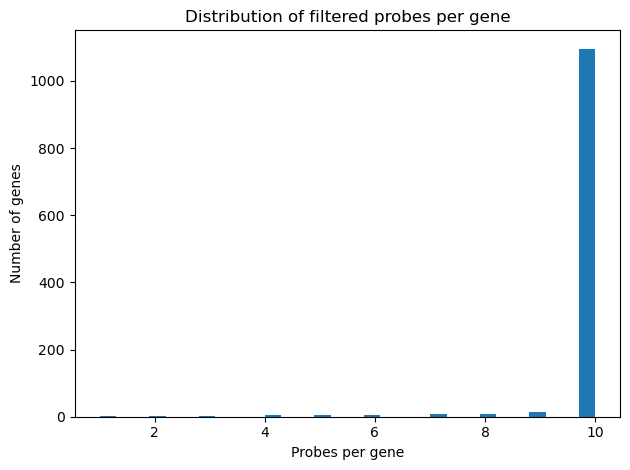

In [58]:
plt.figure()
bins = 30
plt.hist(counts["n_probes"], bins=bins)
plt.xlabel("Probes per gene")
plt.ylabel("Number of genes")
plt.title("Distribution of filtered probes per gene")
plt.tight_layout()
plt.show()


In [59]:
probe_keep_df

,padlock_name,gene_name,acronym,target,transcript_region,startpos,endpos,barcode,RT primer,padlock,keep_1st_round,keep_2nd_round,rank_off_target_combined,rank_tm_melting_diff,rank_binding_fraction,rank_overall_best,overall_percentile,rank_in_gene_best
0,padlock_00001,Olfr869,Or7e175,AACAACACAGAAGCACAGAATCTACCAGTTGTCTCACAGT,['CDS'],37,76,CACTATCGTC,ACTGTGAGACAACTGGTAGA,TCTACCAGTTGTCTCACAGTATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,263,8105.0,1362.0,0.044999,2.0
1,padlock_00002,Olfr869,Or7e175,GAGAACGTAGAAGTACAGCCTTTCCTACTTGTGCTGTTTT,['CDS'],97,136,CACTATCGTC,AAAACAGCACAAGTAGGAAA,TTTCCTACTTGTGCTGTTTTATCGTCGGACTGTAGAACTCTGAACC...,True,True,25215,9780,7347.0,15885.0,0.525102,10.0
3,padlock_00004,Olfr869,Or7e175,GTGCTACAATTTACACACTTCAGTGGCATGGAAATCTCTA,['CDS'],529,568,CACTATCGTC,TAGAGATTTCCATGCCACTG,CAGTGGCATGGAAATCTCTAATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,14112,19473.0,11076.0,0.366126,6.0
7,padlock_00008,Olfr869,Or7e175,GAACAGCTACTGCAGTATACATTGGTTCAACCTCATCATA,['CDS'],800,839,CACTATCGTC,TATGATGAGGTTGAACCAAT,ATTGGTTCAACCTCATCATAATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,6086,22691.0,12458.0,0.411803,8.0
9,padlock_00010,Olfr869,Or7e175,CATCTACAGCCTGAGGAACAGGGACATTAAAATTGCCCTA,['CDS'],906,945,CACTATCGTC,TAGGGCAATTTTAATGTCCC,GGGACATTAAAATTGCCCTAATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,14436,10140.0,6811.0,0.225129,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30553,padlock_30554,Taar6,Taar6,CAAGTTCACGGTGTCTGTGTCTGGAATTTGCATCGGCGTC,['CDS'],426,465,CATCGCCTTT,GACGCCGATGCAAATTCCAG,CTGGAATTTGCATCGGCGTCATCGTCGGACTGTAGAACTCTGAACC...,True,True,28862,7782,1091.0,25437.0,0.840908,10.0
30555,padlock_30556,Taar6,Taar6,GGCCTGGAGGAATTATCCAGTGCCCTCAACTGCGTAGGGG,['CDS'],526,565,CATCGCCTTT,CCCCTACGCAGTTGAGGGCA,TGCCCTCAACTGCGTAGGGGATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,23474,16851.0,15278.0,0.505040,5.0
30557,padlock_30558,Taar6,Taar6,CTACAGCATTGATTCATTAGTTGATGCTTTTATGGGCTTC,['CDS'],819,858,CATCGCCTTT,GAAGCCCATAAAAGCATCAA,TTGATGCTTTTATGGGCTTCATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,18744,23476.0,15845.0,0.523780,6.0
30558,padlock_30559,Taar6,Taar6,CTCAGCCATGAACCCTCTGATCTACGCTTTATTTTATCCA,['CDS'],909,948,CATCGCCTTT,TGGATAAAATAAAGCGTAGA,TCTACGCTTTATTTTATCCAATCGTCGGACTGTAGAACTCTGAACC...,True,True,1,27938,18083.0,23335.0,0.771401,9.0


In [60]:
# check if any criteria are in worst-10%:

N_total = len(probe_final_df)
threshold = int(0.9 * N_total)  

rank_cols = [
    "rank_off_target_combined",
    "rank_tm_melting_diff",
    "rank_binding_fraction",
]

denom = len(probe_final_df)

for col in rank_cols:

    # compare numerically; ignore non-numeric/NaN
    s = probe_keep_df[col]
    count_worst = (s > threshold).sum()  # NaNs won't be counted
    pct = 100.0 * count_worst / denom

    print(f"Number of kept probes in worst 10% for {col}: {pct:.2f}%")

Number of kept probes in worst 10% for rank_off_target_combined: 0.77%
Number of kept probes in worst 10% for rank_tm_melting_diff: 0.26%
Number of kept probes in worst 10% for rank_binding_fraction: 0.27%


In [61]:
probe_final_df.to_csv(f'{out_folder}/filtered_probe_set_all_102825.csv')
probe_keep_df.to_csv(f'{out_folder}/filtered_probe_set_keep_102825.csv')